# Analysing data of the telecom operator
## determine profitability of two prepaid plans
### analysis plan:
1. describe data in general
2. fix data
    * NA 
    * outliers
    * anomalies
3. prepare data
    * create supporting variables
4. analyze clients' behavior
    * explore some correlations
    * build plots
    * find measures of average and variance
6. test hypotheses
    * find the average profit difference of two plans
    * find the average profit difference from the users form two regions
7. and determine which prepaid plan is more profitable

## Describe data

In [1]:
import pandas as pd
import os
import math
from scipy import stats as st
import matplotlib.pyplot as plt

#import plotly.graph_objects as go
from plotly import graph_objects as go

from matplotlib import pyplot
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
cd = os.getcwd()

df_calls = pd.read_csv(cd + '/datasets/data telecom operator Megaline/megaline_calls.csv')
df_internet = pd.read_csv(cd + '/datasets/data telecom operator Megaline/megaline_internet.csv')
df_messages = pd.read_csv(cd + '/datasets/data telecom operator Megaline/megaline_messages.csv')
df_plans = pd.read_csv(cd + '/datasets/data telecom operator Megaline/megaline_plans.csv')
df_users = pd.read_csv(cd + '/datasets/data telecom operator Megaline/megaline_users1.csv')

data = [df_calls, df_internet, df_messages, df_plans, df_users]
print(data)

[              id  user_id   call_date  duration
0        1000_93     1000  2018-12-27      8.52
1       1000_145     1000  2018-12-27     13.66
2       1000_247     1000  2018-12-27     14.48
3       1000_309     1000  2018-12-28      5.76
4       1000_380     1000  2018-12-30      4.22
...          ...      ...         ...       ...
137730  1499_199     1499  2018-11-21      8.72
137731  1499_200     1499  2018-10-20     10.89
137732  1499_201     1499  2018-09-21      8.12
137733  1499_202     1499  2018-10-10      0.37
137734  1499_203     1499  2018-12-29     13.86

[137735 rows x 4 columns],               id  user_id session_date  mb_used
0        1000_13     1000   2018-12-29    89.86
1       1000_204     1000   2018-12-31     0.00
2       1000_379     1000   2018-12-28   660.40
3       1000_413     1000   2018-12-26   270.99
4       1000_442     1000   2018-12-27   880.22
...          ...      ...          ...      ...
104820  1499_215     1499   2018-10-20   218.06
104821  149

In [3]:
def descr_data_list(data):
    n = 0
    for df in data:
        n += 1
        print('Data', n)
        print('head')
        print(df.head())
        print()
        print('info')
        print(df.info())
        print()
        print('isna')
        print(df.isna().sum().sort_values(ascending=False))
        print()
        print('describe')
        print(df.describe())
        print()
        print()
        
descr_data_list(data)

Data 1
head
         id  user_id   call_date  duration
0   1000_93     1000  2018-12-27      8.52
1  1000_145     1000  2018-12-27     13.66
2  1000_247     1000  2018-12-27     14.48
3  1000_309     1000  2018-12-28      5.76
4  1000_380     1000  2018-12-30      4.22

info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB
None

isna
duration     0
call_date    0
user_id      0
id           0
dtype: int64

describe
             user_id       duration
count  137735.000000  137735.000000
mean     1247.658046       6.745927
std       139.416268       5.839241
min      1000.000000       0.000000
25%      1128.000000       1.290

In [4]:
df_users['city'].sort_values().unique()
df_users['plan'].value_counts()

surf        339
ultimate    161
Name: plan, dtype: int64

As we can see, data need some fixes: change format of date and fill na for var *'churn_date'* in *df_users*.

## Fix data

In [5]:
df_calls['call_date'] = pd.to_datetime(df_calls['call_date'], format='%Y-%m-%d')
df_internet['session_date'] = pd.to_datetime(df_internet['session_date'], format='%Y-%m-%d')
df_messages['message_date'] = pd.to_datetime(df_messages['message_date'], format='%Y-%m-%d')
df_users['reg_date'] = pd.to_datetime(df_users['reg_date'], format='%Y-%m-%d')
df_users['churn_date'] = pd.to_datetime(df_users['churn_date'], format='%Y-%m-%d')

df_users['churn_date'][df_users['churn_date'].isna()] = df_calls['call_date'].max()

In [6]:
last_call = df_calls.groupby('user_id')['call_date'].max().reset_index() 
df_users_lastcall = df_users.merge(last_call, how='left', on='user_id')
print(len(df_users_lastcall[df_users_lastcall['churn_date']<df_users_lastcall['call_date']]), 'rows - abnormal data. Calls were made after the user left.')

30 rows - abnormal data. Calls were made after the user left.


## Prepare data

[]

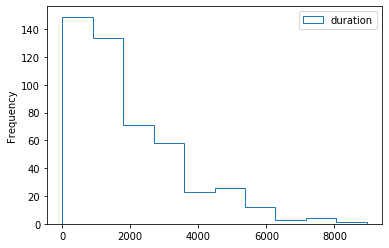

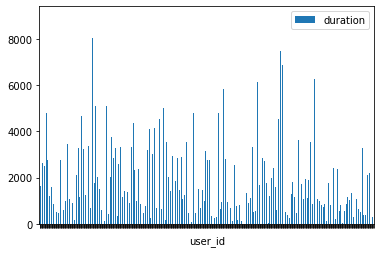

In [7]:
#calls by month

calls_month = df_calls
calls_month['month'] = calls_month['call_date'].values.astype('datetime64[M]')
calls_user_month = calls_month.groupby(['user_id', 'month'])['duration'].agg('sum').reset_index()

(calls_month
    .groupby(['user_id'])['duration']
    .agg('sum')
    .reset_index()
    .plot(x='user_id',y='duration',kind='hist',histtype='step'))
(calls_month
    .groupby(['user_id'])['duration']
    .agg('sum')
    .reset_index()
    .plot(x='user_id',y='duration',kind='bar')
    .set_xticklabels([]))

[]

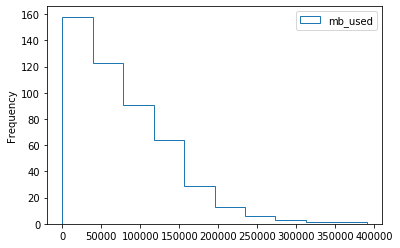

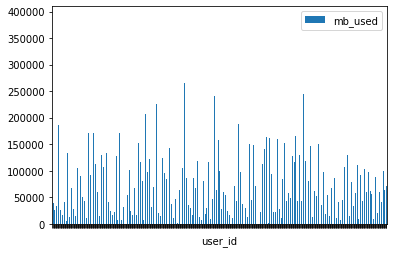

In [8]:
#ineternet by month

internet_month = df_internet
internet_month['month'] = internet_month['session_date'].values.astype('datetime64[M]')
internet_user_month = internet_month.groupby(['user_id','month'])['mb_used'].agg('sum').reset_index()

(internet_month
    .groupby(['user_id'])['mb_used']
    .agg('sum')
    .reset_index()
    .plot(x='user_id',y='mb_used',kind='hist',histtype='step'))
(internet_month
    .groupby(['user_id'])['mb_used']
    .agg('sum')
    .reset_index()
    .plot(x='user_id',y='mb_used',kind='bar')
    .set_xticklabels([]))

[]

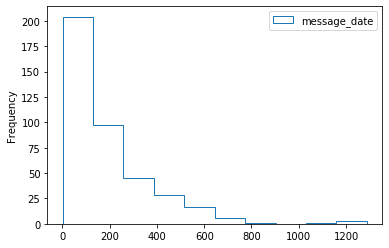

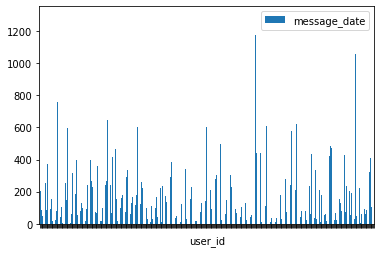

In [9]:
#messeges by month

messages_month = df_messages
messages_month['month'] = messages_month['message_date'].values.astype('datetime64[M]')
messages_user_month = messages_month.groupby(['user_id','month'])['message_date'].agg('count').reset_index()

(messages_month
    .groupby(['user_id'])['message_date']
    .agg('count')
    .reset_index()
    .plot(x='user_id',y='message_date',kind='hist',histtype='step'))
(messages_month
    .groupby(['user_id'])['message_date']
    .agg('count')
    .reset_index()
    .plot(x='user_id',y='message_date',kind='bar')
    .set_xticklabels([]))

Here I prepared three tables with data by minutes, messages and traffic, for their subsequent joining with the main table of the report. To do this, I grouped the data by user and month. Pre-creating a column with months.

In [10]:
min_month = df_calls['call_date'].values.astype('datetime64[M]').min()-1
max_month = df_calls['call_date'].values.astype('datetime64[M]').max()
dr = pd.DataFrame(pd.date_range(min_month,max_month,freq='MS'))
dr.columns = ['month']
dr['key'] = 1

df_users['key'] = 1
users_report = dr.merge(df_users,on='key')

users_report['reg_month'] = users_report['reg_date'].values.astype('datetime64[M]')
users_report['churn_month'] = users_report['churn_date'].values.astype('datetime64[M]')

users_report = users_report[users_report['month'] >= users_report['reg_month']]
users_report = users_report[users_report['month'] <= users_report['churn_month']]

users_report = users_report.groupby(['user_id', 'month'])['plan','city'].min().reset_index()

report = users_report.merge(calls_user_month,how='left',on=['user_id','month'])
report = report.merge(internet_user_month,how='left',on=['user_id','month'])
report = report.merge(messages_user_month,how='left',on=['user_id','month'])

# report[report['user_id']==1191]
# report[report['user_id']==1008]

# df_calls[df_calls['user_id']==1002].groupby('month')['duration'].agg('sum').reset_index()
# calls_user_month[calls_user_month['user_id']==1002]
# internet_user_month[internet_user_month['user_id']==1002]

In [11]:
report

,user_id,month,plan,city,duration,mb_used,message_date
0,1000,2018-12-01,ultimate,"Atlanta-Sandy Springs-Roswell, GA MSA",116.83,1901.47,11.0
1,1001,2018-08-01,surf,"Seattle-Tacoma-Bellevue, WA MSA",171.14,6919.15,30.0
2,1001,2018-09-01,surf,"Seattle-Tacoma-Bellevue, WA MSA",297.69,13314.82,44.0
3,1001,2018-10-01,surf,"Seattle-Tacoma-Bellevue, WA MSA",374.11,22330.49,53.0
4,1001,2018-11-01,surf,"Seattle-Tacoma-Bellevue, WA MSA",404.59,18504.30,36.0
...,...,...,...,...,...,...,...
3308,1499,2018-08-01,surf,"Orlando-Kissimmee-Sanford, FL MSA",NaN,NaN,NaN
3309,1499,2018-09-01,surf,"Orlando-Kissimmee-Sanford, FL MSA",330.37,12984.76,NaN
3310,1499,2018-10-01,surf,"Orlando-Kissimmee-Sanford, FL MSA",363.28,19492.43,NaN
3311,1499,2018-11-01,surf,"Orlando-Kissimmee-Sanford, FL MSA",288.56,16813.83,NaN


In [12]:
report.columns = ['user_id', 'month', 'plan', 'city', 'minutes_used', 'mb_used', 'message_used']
report

,user_id,month,plan,city,minutes_used,mb_used,message_used
0,1000,2018-12-01,ultimate,"Atlanta-Sandy Springs-Roswell, GA MSA",116.83,1901.47,11.0
1,1001,2018-08-01,surf,"Seattle-Tacoma-Bellevue, WA MSA",171.14,6919.15,30.0
2,1001,2018-09-01,surf,"Seattle-Tacoma-Bellevue, WA MSA",297.69,13314.82,44.0
3,1001,2018-10-01,surf,"Seattle-Tacoma-Bellevue, WA MSA",374.11,22330.49,53.0
4,1001,2018-11-01,surf,"Seattle-Tacoma-Bellevue, WA MSA",404.59,18504.30,36.0
...,...,...,...,...,...,...,...
3308,1499,2018-08-01,surf,"Orlando-Kissimmee-Sanford, FL MSA",NaN,NaN,NaN
3309,1499,2018-09-01,surf,"Orlando-Kissimmee-Sanford, FL MSA",330.37,12984.76,NaN
3310,1499,2018-10-01,surf,"Orlando-Kissimmee-Sanford, FL MSA",363.28,19492.43,NaN
3311,1499,2018-11-01,surf,"Orlando-Kissimmee-Sanford, FL MSA",288.56,16813.83,NaN


A table with user data was multiplied by a table with a range of months. Further, months before and Metz were excluded after connecting to the tariff plan. And finally, I combined all four tables into one big report table.

# Final Report table

In [13]:
df_plans

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


In [14]:
for index in range(len(report)):
    user = report.loc[index]

    if 'surf' in str(user['plan']):
        #pay for minutes per month
        over_min = user['minutes_used'] - df_plans.loc[0]['minutes_included']
        if over_min > 0:
            over_pay_min = over_min * df_plans.loc[0]['usd_per_minute']
        else:
            over_pay_min = 0
        #pay for mb(internet) per month    
        over_mb = user['mb_used'] - df_plans.loc[0]['mb_per_month_included']
        if over_mb > 0:
            over_pay_mb = math.ceil(over_mb/1000) * df_plans.loc[0]['usd_per_minute']
        else:
            over_pay_mb = 0
        #pay for messages per month    
        over_mess = user['message_used'] - df_plans.loc[0]['messages_included']
        if over_mess > 0:
            over_pay_mess = over_mess * df_plans.loc[0]['usd_per_message']
        else:
            over_pay_mess = 0
        #total pay per month
        total_per_month = df_plans.loc[0]['usd_monthly_pay'] + over_pay_min + over_pay_mb + over_pay_mess
        report.loc[index,'revenue'] = total_per_month

    else:
        #pay for minutes per month
        over_min = user['minutes_used'] - df_plans.loc[1]['minutes_included']
        if over_min > 0:
            over_pay_min = over_min * df_plans.loc[1]['usd_per_minute']
        else:
            over_pay_min = 0
        #pay for mb(internet) per month    
        over_mb = user['mb_used'] - df_plans.loc[1]['mb_per_month_included']
        if over_mb > 0:
            over_pay_mb = math.ceil(over_mb/1000) * df_plans.loc[1]['usd_per_minute']
        else:
            over_pay_mb = 0
        #pay for messages per month    
        over_mess = user['message_used'] - df_plans.loc[1]['messages_included']
        if over_mess > 0:
            over_pay_mess = over_mess * df_plans.loc[1]['usd_per_message']
        else:
            over_pay_mess = 0
        #total pay per month
        total_per_month = df_plans.loc[1]['usd_monthly_pay'] + over_pay_min + over_pay_mb + over_pay_mess
        report.loc[index,'revenue'] = total_per_month

report

,user_id,month,plan,city,minutes_used,mb_used,message_used,revenue
0,1000,2018-12-01,ultimate,"Atlanta-Sandy Springs-Roswell, GA MSA",116.83,1901.47,11.0,70.00
1,1001,2018-08-01,surf,"Seattle-Tacoma-Bellevue, WA MSA",171.14,6919.15,30.0,20.00
2,1001,2018-09-01,surf,"Seattle-Tacoma-Bellevue, WA MSA",297.69,13314.82,44.0,20.00
3,1001,2018-10-01,surf,"Seattle-Tacoma-Bellevue, WA MSA",374.11,22330.49,53.0,20.30
4,1001,2018-11-01,surf,"Seattle-Tacoma-Bellevue, WA MSA",404.59,18504.30,36.0,20.12
...,...,...,...,...,...,...,...,...
3308,1499,2018-08-01,surf,"Orlando-Kissimmee-Sanford, FL MSA",NaN,NaN,NaN,20.00
3309,1499,2018-09-01,surf,"Orlando-Kissimmee-Sanford, FL MSA",330.37,12984.76,NaN,20.00
3310,1499,2018-10-01,surf,"Orlando-Kissimmee-Sanford, FL MSA",363.28,19492.43,NaN,20.15
3311,1499,2018-11-01,surf,"Orlando-Kissimmee-Sanford, FL MSA",288.56,16813.83,NaN,20.06


I wrote a condition according to which each variable for each user for each month was checked for exceeding tariff limits, pre-sorting according to two plans. As a result, a new column was created with revenue for each month for each user.

## Check report table

in report controll sum is less because there is an anomaly in the data. there are users who allegedly made calls after the service was disconnected. I ruled out these calls as anomalies.

In [15]:
df_calls[df_calls['user_id']==1191]['duration'].sum()

3528.26

In [16]:
report[report['user_id']==1191]['minutes_used'].sum()

2937.6099999999997

with other users, everything is fine

In [17]:
report[report['user_id']==1002]['minutes_used'].sum()

777.1299999999999

In [18]:
report[report['user_id']==1002]['minutes_used'].sum()

777.1299999999999

In [19]:
len(report[report['revenue']!=20][report['revenue']!=70])

1145

### From month to month, total revenue increased

In [20]:
report.groupby('month')['revenue'].agg('sum').reset_index()

,month,revenue
0,2018-01-01,1930.0000
1,2018-02-01,3378.7006
2,2018-03-01,4685.0260
3,2018-04-01,6165.8650
4,2018-05-01,7643.2569
5,2018-06-01,9854.4913
6,2018-07-01,11273.9950
7,2018-08-01,13010.0150
8,2018-09-01,14124.0168
9,2018-10-01,15483.3386


### Users of the surf plan are twice as many. but despite this, the ultimate plan brought 64% more profit.

In [21]:
plans_revenue = report.groupby('plan')['revenue'].agg('sum').reset_index()
plans_revenue.loc[0, 'revenue_by_user'] = plans_revenue.loc[0, 'revenue'] / len(report[report['plan']=='surf'])
plans_revenue.loc[1, 'revenue_by_user'] = plans_revenue.loc[1, 'revenue'] / len(report[report['plan']=='ultimate'])

In [22]:
plans_revenue

,plan,revenue,revenue_by_user
0,surf,47633.099,21.245807
1,ultimate,74972.450,70.002288


In [23]:
len(report[report['plan']=='surf']) / len(report[report['plan']=='ultimate'])

2.093370681605976

In [24]:
plans_revenue.loc[0,'revenue'] / plans_revenue.loc[1,'revenue']

0.6353413687294462

# Сorr matrix. Users behavior

In [43]:
#print(pd.plotting.scatter_matrix(report, figsize=(15,15)))

Preliminary analysis reveals that the data behaves as expected. The resulting distributions require a more detailed analysis.

In [44]:
index_vals = report['plan'].astype('category').cat.codes
fig = go.Figure(data=go.Splom(
                dimensions=[dict(label='minutes_used',
                                 values=report['minutes_used']),
                            dict(label='mb_used',
                                 values=report['mb_used']),
                            dict(label='message_used',
                                 values=report['message_used']),
                            dict(label='revenue',
                                 values=report['revenue'])],
                text=report['plan'],
                marker=dict(color=index_vals,
                            showscale=False, # colors encode categorical variables
                            line_color='white', line_width=0.5
                           )
                ))


fig.update_layout(
    title='Correlation report for two mobile operator tariff plans',
    dragmode='select',
    width=900,
    height=900,
    hovermode='closest',
)

fig.show()

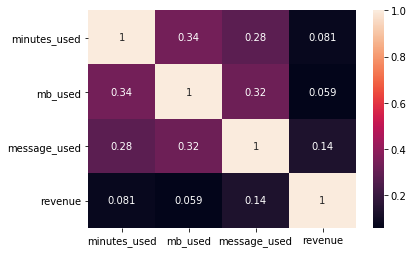

In [28]:
data = {'A': [45,37,42,35,39],
        'B': [38,31,26,28,33],
        'C': [10,15,17,21,12]
        }

df = pd.DataFrame(report,columns=['minutes_used', 'mb_used',
       'message_used', 'revenue'])

corrMatrix = df.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

# histograms of users behavior

In [29]:
print(df_plans)

   messages_included  mb_per_month_included  minutes_included  \
0                 50                  15360               500   
1               1000                  30720              3000   

   usd_monthly_pay  usd_per_gb  usd_per_message  usd_per_minute plan_name  
0               20          10             0.03            0.03      surf  
1               70           7             0.01            0.01  ultimate  


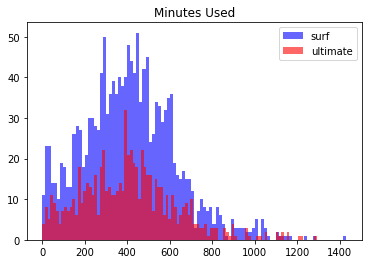

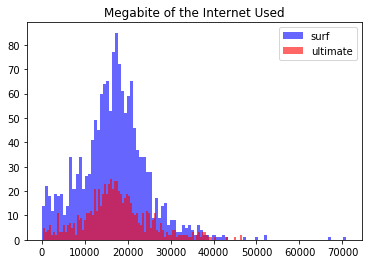

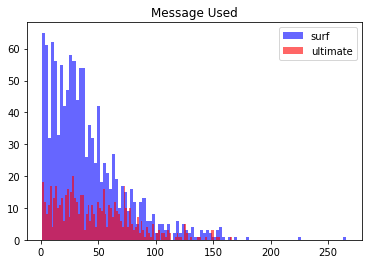

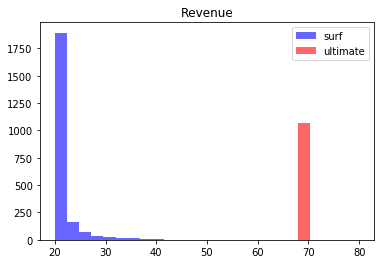

In [30]:
# report[report['plan']=='surf'].hist()
# report[report['plan']=='ultimate'].hist()

pyplot.hist(report[report['plan']=='surf']['minutes_used'], bins=100, alpha=.6, label='surf', color='blue')
pyplot.hist(report[report['plan']=='ultimate']['minutes_used'], bins=100, alpha=.6, label='ultimate', color='red')
pyplot.legend(loc='upper right')
pyplot.title(label='Minutes Used', fontdict=None, loc='center', pad=None)
pyplot.show()

pyplot.hist(report[report['plan']=='surf']['mb_used'], bins=100, alpha=.6, label='surf', color='blue')
pyplot.hist(report[report['plan']=='ultimate']['mb_used'], bins=100, alpha=.6, label='ultimate', color='red')
pyplot.legend(loc='upper right')
pyplot.title(label='Megabite of the Internet Used', fontdict=None, loc='center', pad=None)
pyplot.show()

pyplot.hist(report[report['plan']=='surf']['message_used'], bins=100, alpha=.6, label='surf', color='blue')
pyplot.hist(report[report['plan']=='ultimate']['message_used'], bins=100, alpha=.6, label='ultimate', color='red')
pyplot.legend(loc='upper right')
pyplot.title(label='Message Used', fontdict=None, loc='center', pad=None)
pyplot.show()

pyplot.hist(report[report['plan']=='surf']['revenue'], bins=25, alpha=.6, range=(20,80), label='surf', color='blue')
pyplot.hist(report[report['plan']=='ultimate']['revenue'], bins=25, alpha=.6, range=(20,80), label='ultimate', color='red')
pyplot.legend(loc='upper right')
pyplot.title(label='Revenue', fontdict=None, loc='center', pad=None)
pyplot.show()

You can see that regardless of the tariff, users behave the same in terms of consumption limits.

# Stat Report table

In [31]:
stat_report = (report
    .pivot_table(
        index=['plan','month'], 
        values=['minutes_used','mb_used','message_used'], 
        aggfunc=['var','std','mean'])
    .reset_index()
)

stat_report

plan      month           var                             \
                              mb_used message_used  minutes_used   
0       surf 2018-01-01  1.823995e+07          NaN  14795.440200   
1       surf 2018-02-01  4.367296e+07   512.800000  46959.219961   
2       surf 2018-03-01  6.824556e+07   352.062500  31821.317991   
3       surf 2018-04-01  5.722187e+07   534.028571  45615.666796   
4       surf 2018-05-01  5.967252e+07   867.945130  50778.127459   
5       surf 2018-06-01  4.509227e+07   936.406393  39424.054023   
6       surf 2018-07-01  6.284327e+07   907.985836  53364.540232   
7       surf 2018-08-01  7.059657e+07  1013.315762  46639.240873   
8       surf 2018-09-01  5.014277e+07   943.051126  39785.302974   
9       surf 2018-10-01  5.982311e+07  1249.551526  44519.937515   
10      surf 2018-11-01  5.573151e+07  1020.738294  44333.453530   
11      surf 2018-12-01  7.041446e+07  1380.905552  54230.474641   
12  ultimate 2018-01-01  1.639471e+07   310.333333  14991.369958   
13  ultimate 2018-02-01  3.764910e+07   465.366667  48579.581537   
14  ultimate 2018-03-01  1.403392e+08   613.904762  54273.917252   
15  ultimate 2018-04-01  8.842861e+07   512.862500  31057.727496   
16  ultimate 2018-05-01  5.679012e+07  1246.933333  39290.610940   
17  ultimate 2018-06-01  7.201453e+07   807.238265  33837.770156   
18  ultimate 2018-07-01  6.841921e+07   858.084181  64844.426958   
19  ultimate 2018-08-01  6.132120e+07  1033.126948  47383.261808   
20  ultimate 2018-09-01  4.899190e+07   902.878943  51882.162986   
21  ultimate 2018-10-01  5.505555e+07  1111.262278  47495.552604   
22  ultimate 2018-11-01  5.831445e+07  1093.480594  54226.583841   
23  ultimate 2018-12-01  6.293770e+07  1384.813440  53559.089464   

             std                                    mean               \
         mb_used message_used minutes_used       mb_used message_used   
0    4270.825963          NaN   121.636508   4874.860000    21.000000   
1    6608.551952    22.645088   216.700761  12178.843333    21.600000   
2    8261.086946    18.763329   178.385308  13345.440000    21.937500   
3    7564.514094    23.109058   213.578245  12228.778571    24.166667   
4    7724.799075    29.460909   225.340026  14119.728026    33.017857   
5    6715.077831    30.600758   198.554914  15623.666632    33.616438   
6    7927.374698    30.132803   231.007663  16923.463917    35.945055   
7    8402.176549    31.832621   215.961202  17112.224403    37.596774   
8    7081.155848    30.709137   199.462535  16677.397254    39.523179   
9    7734.540068    35.348996   210.997482  17545.206130    42.193548   
10   7465.353853    31.948995   210.555108  16494.740985    40.877273   
11   8391.332557    37.160538   232.874375  18241.412772    48.221311   
12   4049.038391    17.616280   122.439250   6918.092500    20.666667   
13   6135.885948    21.572359   220.407762  17128.808571    25.166667   
14  11846.483246    24.777102   232.967631  18321.518333    34.714286   
15   9403.648604    22.646468   176.232027  16121.654762    28.937500   
16   7535.921701    35.311943   198.218594  16624.482414    44.333333   
17   8486.137619    28.411939   183.950456  15337.921064    36.289474   
18   8271.590578    29.293074   254.645689  16344.744407    41.212766   
19   7830.785156    32.142292   217.676967  17809.540714    48.517857   
20   6999.421143    30.047944   227.776564  17155.735357    46.724638   
21   7419.942764    33.335601   217.934744  17787.863462    47.045455   
22   7636.389872    33.067818   232.866021  17129.104435    48.138614   
23   7933.328530    37.213082   231.428368  18305.598288    54.524590   

                 
   minutes_used  
0    192.840000  
1    280.851111  
2    310.970000  
3    332.380000  
4    387.108000  
5    411.450625  
6    428.060917  
7    394.474717  
8    397.133298  
9    413.670132  
10   409.741519  
11   459.761818  
12   183.162500  
13   443.171667  
14   285.701667  
15   316.508095  
16   383.664828 

Text(0.5, 1.0, 'Message Used')

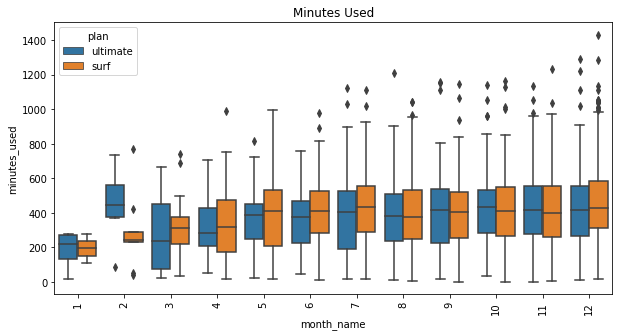

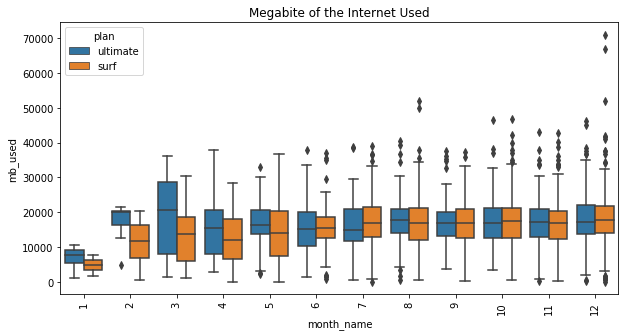

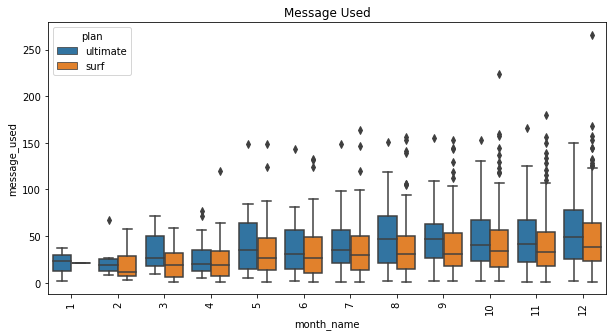

In [32]:
report['month_name'] = pd.to_datetime(report['month'], format='%m').dt.month

plt.figure(figsize=(10,5))
sns.boxplot(y='minutes_used', x='month_name', 
                 data=report, 
                 #palette="colorblind",
                #dodge=True,
                 hue='plan')
plt.xticks(rotation=90)
plt.title('Minutes Used')

plt.figure(figsize=(10,5))
sns.boxplot(y='mb_used', x='month_name', 
                 data=report, 
                 #palette="colorblind",
                #dodge=True,
                 hue='plan')
plt.xticks(rotation=90)
plt.title('Megabite of the Internet Used')

plt.figure(figsize=(10,5))
sns.boxplot(y='message_used', x='month_name', 
                 data=report, 
                 #palette="colorblind",
                #dodge=True,
                 hue='plan')
plt.xticks(rotation=90)
plt.title('Message Used')

As can be seen from the measures taken of the central tendency and dispersion, from month to month users do not change their behavior regardless of the plan. It is worth noting that the first three months in the data differ from the subsequent ones, since there were fewer users in the sample.

# 1. Hypothesis: 
## the average profit from users of Ultimate and Surf calling plans differs

This is bilateral hypothes. In other words, we will not know more or less one tariff in relation to another. We will find out if the average profit differs in tariffs in general. Besides profit, it was also interesting to see if the average use of limits is different.

In [33]:
surf = report[report['plan'] == 'surf']
surf = surf.dropna()
ultimate = report[report['plan'] == 'ultimate']
ultimate = ultimate.dropna()

#First hypothesis
print("Null hypothesis - minutes mean of two plas are equal")
results_minutes = st.ttest_ind(
        surf['minutes_used'], 
        ultimate['minutes_used'])
print('p-value: ', results_minutes.pvalue.round(4))
if (results_minutes.pvalue < 0.05):
        print("We reject the null hypothesis")
else:
        print("We can't reject the null hypothesis")
print()

#Second
print("Null hypothesis - mb mean of two plas are equal")
results_mb = st.ttest_ind(
        surf['mb_used'], 
        ultimate['mb_used'])
print('p-value: ', results_mb.pvalue.round(4))
if (results_mb.pvalue < 0.05):
        print("We reject the null hypothesis")
else:
        print("We can't reject the null hypothesis")
print()

#Fird
print("Null hypothesis - sms mean of two plas are equal")
results_message = st.ttest_ind(
        surf['message_used'], 
        ultimate['message_used'])
print('p-value: ', results_message.pvalue.round(10))
if (results_message.pvalue < 0.05):
        print("We reject the null hypothesis")
else:
        print("We can't reject the null hypothesis")
print()

#Forth
print("Null hypothesis - revenue mean of two plas are equal")
results_revenue = st.ttest_ind(
        surf['revenue'], 
        ultimate['revenue'])
print('p-value: ', results_revenue.pvalue.round(10))
if (results_revenue.pvalue < 0.05):
        print("We reject the null hypothesis")
else:
        print("We can't reject the null hypothesis")

Null hypothesis - minutes mean of two plas are equal
p-value:  0.7471
We can't reject the null hypothesis

Null hypothesis - mb mean of two plas are equal
p-value:  0.0991
We can't reject the null hypothesis

Null hypothesis - sms mean of two plas are equal
p-value:  1.02492e-05
We reject the null hypothesis

Null hypothesis - revenue mean of two plas are equal
p-value:  0.0
We reject the null hypothesis


As we can see, the average tariffs for messages and for profit differ significantly. I used a significance level of 0.05.

# 2. Hypothesis: 
## the average profit from users in NY-NJ area is different from that of the users from other regions.

In [34]:
report_city_ny_nj = report[report['city'].str.contains('NY-NJ')]
report_other_cities = report[~report['city'].str.contains('NY-NJ')]

print("Null hypothesis - revenue mean of two places are equal")
results_revenue = st.ttest_ind(
        report_city_ny_nj['revenue'], 
        report_other_cities['revenue'])
print('p-value: ', results_revenue.pvalue.round(10))
if (results_revenue.pvalue < 0.01):
        print("We reject the null hypothesis")
else:
        print("We can't reject the null hypothesis")

Null hypothesis - revenue mean of two places are equal
p-value:  1.2e-08
We reject the null hypothesis


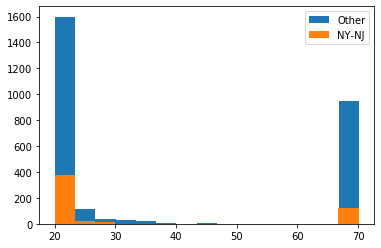

In [35]:
# plt.hist(report_city_ny_nj['revenue'])
# plt.hist(report_another_cities['revenue'])
# plt.show()

pyplot.hist(report_other_cities['revenue'], bins=15, alpha=1, label='Other')
pyplot.hist(report_city_ny_nj['revenue'], bins=15, alpha=1, label='NY-NJ')
pyplot.legend(loc='upper right')
pyplot.show()

Oddly enough, Student's test showed that the average profit for the regional sample NY-NJ showed a significant difference from all other regions.

# Summary

I have conducted an analysis of a sample of clients of a mobile operator’s network. The data obtained indicate that of the two tariffs, the second most profitable for the operator is “ultimate”. This tariff brings more profit, despite the fact that users are half as much. In addition, users of this tariff use their limits, as well as users of the first cheaper tariff "surf". The established difference in tariff profitability is statistically significant. In other words, the difference is not within the statistical error.